In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import torch#, time
import torch.nn as nn
device = torch.device("cpu")# torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.preprocessing import OneHotEncoder
import matplotlib.animation as animation
from IPython.display import HTML
from misc_tools.print_latex import print_tex

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

For derivation see GNN_Attention_notes.ipynb
Im not sure whether implement unique $\vec{a}$ for all heads. Original paper hints on that. Implementation i have found reuses it.


In [2]:
np.random.seed(1337)
#G = nx.house_graph()
N = 3
G = nx.gnm_random_graph(N, 2*N)

A = nx.adjacency_matrix(G).todense()
print_tex('A = ', A)
A = torch.tensor(A)

<IPython.core.display.Math object>

In [3]:
#N_FEATURES, N_NODES = A.shape
N_NODES = len(G.nodes())
N_FEATURES = 2
N_HIDDEN = 2
N_HEADS = 2
OUT_FEATURES = 2

In [4]:
H = torch.arange(N_NODES*N_FEATURES, dtype = float).view(N_NODES, N_FEATURES) + 1
print_tex('H = ', H.numpy())

<IPython.core.display.Math object>

In [5]:
class debug_net(nn.Module):
    def __init__(self, H0, A, test = False):
        super(debug_net, self).__init__()
        self.H = H0
        self.A = A
        self.W_gh   = nn.Linear(in_features=N_FEATURES, out_features=N_HEADS*N_HIDDEN, bias=False, dtype=H0.dtype)
        self.Gk     = torch.zeros(size=(N_NODES, N_HEADS*N_HIDDEN), dtype=H0.dtype)
        self.GkR    = self.Gk.view(N_NODES, N_HEADS, N_FEATURES)
        self.Ck_l   = torch.zeros(size=(N_NODES*N_NODES, N_HEADS, N_HIDDEN), dtype=H0.dtype) 
        self.Ck_r   = torch.zeros_like(self.Ck_l)
        self.Ck_f   = torch.zeros(size=(N_NODES*N_NODES, N_HEADS, 2*N_HIDDEN), dtype=H0.dtype) 
        self.Ck     = self.Ck_f.view(N_NODES, N_NODES, N_HEADS, 2*N_HIDDEN)
        self.attnt  = nn.Parameter(torch.zeros(size=(2*N_HIDDEN, N_HEADS), dtype=H0.dtype))
        self.activ  = nn.LeakyReLU(0.2)
        self.E      = torch.zeros(size=(N_NODES,N_NODES, N_HEADS), dtype=H0.dtype)
        self.alpha  = torch.zeros_like(self.E)
        self.softmax= nn.Softmax(dim = 1)
        self.GkPrime= torch.zeros_like(self.GkR)
         
        if test:
            self.debug()

    def debug(self):
        with torch.no_grad():
            print_tex(r'N_{nodes} = '+ str(N_NODES) + r'; \ N_{heads} = '+ str(N_HEADS) + r'; \ N_{features} = '+ str(N_FEATURES)+ r'; \ N_{hidden} = '+ str(N_HIDDEN))
            print_tex(r'G_{K} \text{ is a matrix of concatenated embeddings } \vec{g}_i^{k} , \ shape : [N_{nodes} \times N_{heads}*N_{hidden}]')

            # set scaling transforms
            for i in range(N_HEADS):
                s = 1 if i == 0 else 4*i

                self.W_gh.weight[i*N_FEATURES:(i+1)*N_FEATURES] = s*torch.eye(N_FEATURES)

            self.Gk += self.W_gh(self.H)        # cannot redefine, it will break a view

            print_tex('G_K = H W_K^T = ', H.numpy() , self.W_gh.weight[:].T.numpy(),' = ', self.Gk.numpy())
            print_tex(r'\text{Reshape } G_{K} \ to \ [N_{nodes} \times N_{heads} \times N_{hidden}] \text{ to isolate each head`s data to its own dimension}')

            print_tex(r"\text{Goal: a matrix } C_K \text{ that holds concatenated node feature pairs. Shape: }[N_{nodes} \times N_{nodes}\times N_{heads} \times 2 N_{hidden}]")
            print("Its only (?) possible with flattening, concatenating and unflattening. See notes.")

            self.Ck_l += self.GkR.repeat_interleave(N_NODES, dim=0)
            self.Ck_r += self.GkR.repeat(N_NODES, 1, 1)
            self.Ck_f += torch.cat([self.Ck_l, self.Ck_r], dim=-1);
            
            print_tex(r'C_{flat} \ (K=1) = Repeat_{flat} \ ||  \ Interleave_{flat} = '
                      ,self.Ck_l[:,[0]].squeeze(1).numpy(),r' \ \bigg|\bigg| \ ', self.Ck_r[:,[0]].squeeze(1).numpy(), ' = ',
                      self.Ck_f[:,[0]].squeeze(1).numpy())
            
            print_tex(r'\text{Features C}_{0,0} = ', self.Ck[0,0].numpy(), r'; \ shape: \ [N_{heads} \times 2 N_{hidden}]')
            prnt_vec = [r'\vec{a}_'+str(i)+ ' = ' for i in range(N_HEADS)]
            prnt_vec2 = [r'^T ; \ ' for i in range(N_HEADS)]

            self.attnt += np.repeat(1/(torch.arange(N_HEADS, dtype=self.H.dtype).unsqueeze(0)+1), repeats=2*N_HIDDEN, axis = 0)
            print_tex(r"\text{Goal: a matrix E that holds edge weights. Shape: }[N_{nodes} \times N_{nodes} \times N_{heads}]")
            print_tex(r'E = \sigma(\vec{a}[C_K])')
            print('Test attention vectors:')
            print_tex(*[l for lists in zip(prnt_vec,self.attnt.T.numpy(),prnt_vec2) for l in lists])
            print('>>>See how to apply multiple attention vectors to data in notes<<<')
            
            self.E += self.activ(torch.einsum('ijkf,fk -> ijk', self.Ck, self.attnt)).squeeze(-1)#

            print_tex(r'\text{Features E}_{0,0} = ', self.E[0,0].numpy())
            self.alpha += self.E.masked_fill(self.A.view(N_NODES,N_NODES,1) == 0, float('-inf'))
            for i in range(N_HEADS):
                print_tex('E_{K='+str(i + 1)+'} = ',self.E.numpy()[:,:,i], r'\rightarrow MASK \rightarrow ',(self.E[:,:,i]*self.A).numpy() )
            print_tex(r"\text{Goal: a matrix } \Alpha \ or \ \alpha \text{ with row-wise softmax normalized weights. Shape: }[N_{nodes} \times N_{nodes} \times N_{heads}]")
            self.alpha = self.softmax(self.alpha)
            
            for i in range(N_HEADS):
                print_tex(r'\alpha_{K='+str(i + 1)+'} = ', self.alpha.numpy()[:,:,i], r'{\rightarrow set \ to \ A \ for \ example \rightarrow }:', self.A.numpy())
                self.alpha.numpy()[:,:,i] = self.A
            self.GkPrime += torch.einsum('ijk,jkf->ikf', self.alpha , self.GkR)

            print_tex(r"\text{Goal: updated features } G_k^\prime \text{ based on aggregation of features } \vec{g}_i^k \text{ with weights } \Alpha \text{ . Shape: }[N_{nodes} \times N_{heads} \times N_{hidden}]")
            print('>>>See how to aggregate multi head case in notes<<<')
            n1_neighbors_id = torch.argwhere(self.A[0] == 1).flatten().numpy()
            
            a = [r'G_'+str(i)+ ' = ' for i in n1_neighbors_id]
            b = [self.GkR[i].numpy() for i in n1_neighbors_id]
            c = [r'; \ ' for i in n1_neighbors_id]
            print_tex(*[l for lists in zip(a,b,c) for l in lists], r'\Alpha|_{row,1}= ', self.alpha[0].numpy() )
            print_tex(r'G_0^\prime = \vec{A}_0 \otimes G = ', self.GkPrime[0].numpy())
            print('New embeddings can be either concatenated across different variants of k or averaged"')
            GkP_concat = self.GkPrime.reshape(N_NODES, N_HEADS * N_HIDDEN)
            GkP_avg  = self.GkPrime.mean(dim=1)
            print_tex(r'G_0^{concat} = ', GkP_concat[0].numpy(), r'; \ G_0^{Avg} = ',GkP_avg[0].numpy())


model = debug_net(H,A,True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Its only (?) possible with flattening, concatenating and unflattening. See notes.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Test attention vectors:


<IPython.core.display.Math object>

>>>See how to apply multiple attention vectors to data in notes<<<


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

>>>See how to aggregate multi head case in notes<<<


<IPython.core.display.Math object>

<IPython.core.display.Math object>

New embeddings can be either concatenated across different variants of k or averaged"


<IPython.core.display.Math object>

In [6]:
class GraphAttentionLayer(nn.Module):
    def __init__(self, N_FEATURES, N_HEADS, N_HIDDEN, non_lin, mask_attention = True, concat: bool = False, l_ReLU_slope: float = 0.2, dropout: float = 0.6, dtype = torch.float):
        super(GraphAttentionLayer, self).__init__()
        # 1) globals
        self.mask_attention = mask_attention
        self.N_FEATURES, self.N_HEADS,  self.N_HIDDEN  = N_FEATURES, N_HEADS, N_HIDDEN
        self.concat = concat
        self.dtype = dtype
        # 2) weights 
        # 2.1) project H0 to G      [N_nodes x N_features] -> [N_nodes x N_hidden]
        self.W_gh   = nn.Linear(in_features=N_FEATURES, out_features=N_HEADS*N_HIDDEN, bias=False, dtype=dtype)
        # 2.2) project Ck to alpha  [N_nodes x N_nodes x N_heads x N_features] -> [N_nodes x N_hidden x N_heads]
        self.attention  = nn.Parameter(torch.empty(size=(2*N_HIDDEN, N_HEADS), dtype=dtype))
        nn.init.xavier_uniform_(self.attention) 
        print(f'{self.attention = }')

        # misc processing
        self.activ_alpha    = nn.LeakyReLU(l_ReLU_slope)
        self.softmax        = nn.Softmax(dim = 1)
        self.activ_Gn_new   = non_lin
        self.dropout        = nn.Dropout(dropout)

    def forward(self, A, H):
        #A,H = A.detach(), H.to(self.dtype).detach()
        H = H.to(self.dtype)
        N_NODES = H.size(0)
        N_HEADS, N_HIDDEN = self.N_HEADS,  self.N_HIDDEN
        # 1) Get features
        Gk_reshaped = self.W_gh(H).view(N_NODES, N_HEADS, N_HIDDEN)
        # 2) Prepare attention/adjacency matrix
        # 2.1) Concatenated pairwise features for each head
        C_left  = Gk_reshaped.repeat_interleave(N_NODES, dim=0)
        C_right = Gk_reshaped.repeat(N_NODES, 1, 1)
        Ck      = torch.cat([C_left, C_right], dim=-1).view(N_NODES, N_NODES, N_HEADS, 2*N_HIDDEN)
        #print(f'{Ck.shape = }')
        # 2.2) Project concat features to a scalar
        alpha   = self.activ_alpha(torch.einsum('ijkf,fk -> ijk', Ck, self.attention)).view(N_NODES, N_NODES, N_HEADS)
        #print(f'{alpha.shape = }')
        # 2.3) Apply adjacency matrix mask, softmax and dropout
        if self.mask_attention:
            alpha.masked_fill_(A.reshape(N_NODES,N_NODES,1) == 0, float('-inf'))
        alpha = self.softmax(alpha)
        alpha = self.dropout(alpha)
        # 3) Calculate new feature vectors by aggregation, using attention matrix.
        Gk_new = torch.einsum('ijk,jkf->ikf', alpha , Gk_reshaped)
        #print(f'{Gk_new.shape = }')
        # 4) Additional processing. Like in paper, its either mean or concat, with activation.
        if self.concat:
            # activation before concat
            Gk_new = self.activ_Gn_new(Gk_new)
            return Gk_new.reshape(N_NODES, N_HEADS * N_HIDDEN)
        else:
            # activation after
            Gk_new = Gk_new.mean(dim=1).view(N_NODES, 1, N_HIDDEN)
            #print(f'mean {Gk_new2.shape = }')
            return self.activ_Gn_new(Gk_new)
        
model = GraphAttentionLayer( N_FEATURES, N_HEADS, N_HIDDEN, nn.Softmax(dim = 2), concat=True)
print_tex(model(A,H).detach().numpy())

self.attention = Parameter containing:
tensor([[ 0.4250, -0.4971],
        [-0.9224,  0.1756],
        [-0.7597, -0.6898],
        [-0.2941,  0.5916]], requires_grad=True)


<IPython.core.display.Math object>

In [7]:

class net(nn.Module):
    def __init__(self, N_FEATURES, N_HEADS, N_HIDDEN):
        super(net, self).__init__()
        N_FEATURES_1, N_FEATURES_2  = N_FEATURES
        N_HEADS_1   , N_HEADS_2     = N_HEADS
        N_HIDDEN_1  , N_HIDDEN_2    = N_HIDDEN

        self.GAT1 = GraphAttentionLayer(N_FEATURES_1, N_HEADS_1, N_HIDDEN_1, nn.ELU(), mask_attention = False, concat = True, dropout = 0.1)
        self.GAT2 = GraphAttentionLayer(N_FEATURES_2, N_HEADS_2, N_HIDDEN_2, nn.Softmax(dim = 2), mask_attention = False, dropout = 0.1)

    def forward(self, A, H):
        x = self.GAT1(A, H)
        y = self.GAT2(A, x)
        return y
    
    

heads   = head_l1, head_l2              = 2, 1
hiddens = hidd_l1, hidd_l2              = 6, 2
feats   = [N_FEATURES, head_l1*hidd_l1]     # feats_l2  takes in concatenated head_l1 features of length hidd_l1

net(feats, heads, hiddens)(A,H)

self.attention = Parameter containing:
tensor([[ 0.5875, -0.1776],
        [ 0.4565, -0.1084],
        [ 0.4624, -0.5211],
        [-0.5068,  0.2714],
        [-0.3093, -0.3280],
        [-0.1937,  0.1979],
        [-0.4456, -0.2873],
        [-0.4162,  0.3382],
        [ 0.5302, -0.4071],
        [ 0.5892, -0.2572],
        [-0.2078,  0.5568],
        [ 0.6398,  0.4390]], requires_grad=True)
self.attention = Parameter containing:
tensor([[0.0535],
        [0.4822],
        [0.0158],
        [0.3689]], requires_grad=True)


tensor([[[0.5757, 0.4243]],

        [[0.5662, 0.4338]],

        [[0.5757, 0.4243]]], grad_fn=<SoftmaxBackward0>)

### 1) Split whole dataset into to independent datasets.
I want to use build-in features for dataset splitting, but for semi-supervised learning meaning of train, test, validation subsets are skewed.
masks:
* train - these features will be available for semi-supervised learning. Rename to `mask_features`
* test - large portion of nodes that will exchange features
* validation - completely isolated graph for validation model

We have to join train and test masks into `masks_train`, so unmasked nodes are on one graph.

**NOTE**: i will be removing nodes with no neighbors, so masks are invalidated

In [8]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import os
torch.manual_seed(69)
num_train_per_class = 100
dataset = Planetoid(    root=os.path.join('data_processing','neural_networks', 'data', 'Planetoid'),
                        name='Cora', 
                        transform=NormalizeFeatures(),
                        split = 'random',
                        num_test= 1000 - 7*num_train_per_class, # to combine into 1000 entries
                        num_val = 500,
                        num_train_per_class= num_train_per_class)
print(f'{dataset.num_features = }, {dataset.num_classes = }')
print(dataset._data)


mask_train      = torch.bitwise_or(dataset.train_mask, dataset.test_mask).bool()

mask_validate = dataset.val_mask.bool()

print('validation and train masks overlap: ', torch.bitwise_and(mask_validate, mask_train).sum().bool().item())

dataset.num_features = 1433, dataset.num_classes = 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
validation and train masks overlap:  False


### 2) Generate graphs- full and two subgraphs (test, validation)
#### 2.1) Lets do a few checks so we know that dataset masks will generate proper slices of list of nodes and proper adjacency matrices will be created.

* Global node names = their pos in range(num_nodes). This will not be true anymore for subgraphs.
* Adjacency and feature matrices are reffed to neighbors by order ID in list(node_names)
* Sort nodes of graphs. This will allow to use dataset.masks for slicing. Makes adj matrix compatible with masked feature matrices.

**Message passing requires that nodes have neighbors. What to do if node does not have any neighbor?**
* Remove unconnected nodes. 
* Introduce self-loops. (It makes no sense for social networks, citations)

In [9]:
# Full graph
G_full = nx.Graph()
nodes_all = torch.arange(len(dataset.y)).numpy()
G_full.add_nodes_from(nodes_all)
G_full.add_edges_from(dataset.edge_index.T.numpy())

# Split it into two unconnected graphs:
G_train0 = G_full.subgraph(nodes_all[mask_train])
G_vali0 = G_full.subgraph(nodes_all[mask_validate])

# Make graphs hold sorted nodes. 
G_train = nx.Graph()
G_train.add_nodes_from(sorted(   G_train0.nodes(data=True)))
G_train.add_edges_from(          G_train0.edges(data=True))

G_vali = nx.Graph()
G_vali.add_nodes_from(sorted(   G_vali0.nodes(data=True)))
G_vali.add_edges_from(          G_vali0.edges(data=True))

# i very much hope that node removal keeps relative order (monotone increase in index)
G_train.remove_nodes_from(list(nx.isolates(G_train)))
G_vali.remove_nodes_from(list(nx.isolates(G_vali)))

# Do a test so we can check if we understand everything correctly
G_vali_nodes = np.array(G_vali.nodes())
print(f'(Ordered) {G_vali_nodes[:10] = }')

# Pick 1st node in subset with neighbors. 
# It will have same or more neighbors than in G_full.
for test_node_ID, test_node in enumerate(G_vali_nodes):
    if len(list(G_vali.neighbors(n=test_node))) > 0: break

print(f'test node global = local name ({test_node = })')
print(f'Global neighbors {list(G_full.neighbors(n=test_node)) = };\nSubgraph neighbors {list(G_vali.neighbors(n=test_node)) = }\n')

# in sugraph it will have 
print(f'Global ID = global entry in nodelist ({test_node = }); \nSubgraph entry = ({test_node_ID = }) -> {G_vali_nodes[test_node_ID] = }\n')

A_train = nx.adjacency_matrix(G_train).astype(bool)
A_vali = nx.adjacency_matrix(G_vali).astype(bool)

# masking by local IDs:
test_node_neighbor_mask = A_vali[[test_node_ID]].todense()[0]
test_node_neighbor_IDs = G_vali_nodes[test_node_neighbor_mask]
print(f'Neighbors via subgraph adjacency matrix: {list(test_node_neighbor_IDs) = }')


(Ordered) G_vali_nodes[:10] = array([ 1,  7, 13, 20, 30, 38, 53, 73, 74, 89], dtype=int64)
test node global = local name (test_node = 1)
Global neighbors list(G_full.neighbors(n=test_node)) = [2, 652, 654];
Subgraph neighbors list(G_vali.neighbors(n=test_node)) = [652]

Global ID = global entry in nodelist (test_node = 1); 
Subgraph entry = (test_node_ID = 0) -> G_vali_nodes[test_node_ID] = 1

Neighbors via subgraph adjacency matrix: list(test_node_neighbor_IDs) = [652]


### 2.2) Obtain and use 'slicers' that will extract node features and targets
* If node list, in subgraphs, is ordered, you can simply apply OG masking.
* If we had nodes w/o neighbors they will be dropped
* Convert labels to OneHot vectors

In [10]:
from sklearn.preprocessing import OneHotEncoder

picker_train = np.array(G_train.nodes())
picker_vali = np.array(G_vali.nodes())
H_train = dataset.x[picker_train]
H_vali = dataset.x[picker_vali]

#print(torch.all(dataset.x[picker_test] == dataset.x[mask_train]).item())

y_train = dataset.y[picker_train]
y_vali = dataset.y[picker_vali]

Y_train = OneHotEncoder(categories='auto').fit_transform(y_train.reshape(-1, 1))
Y_train = torch.tensor(Y_train.todense());

Y_vali = OneHotEncoder(categories='auto').fit_transform(y_vali.reshape(-1, 1))
Y_vali = torch.tensor(Y_vali.todense());

#ill be masking features in the loop


# Masked Cross Entropy Loss loss:
for a row of $H_i$ and $P_i$, if $H_{i,k}$ is true solution since only $P_{i,k} = 1$, then
$$L_i=
-Log\left(\frac{exp(H_{i,k})}{\sum_j exp(H_{i,j})}\right) = -Log\left(\frac{a_i}{b_i}\right) 
$$

1. calc $exp(H_{i,j}) = H_{i,j}^e $

2. calc $H_{i,k}^e = a_i$
$$H_{i,k}^e = sum(H_i^e \otimes P_i) = 
sum(\begin{bmatrix}
H_{i,1}^e  & \dots & H_{i,k}^e & \dots
\end{bmatrix}\otimes
\begin{bmatrix}
0 & \dots & P_{i,k} = 1 & \dots
\end{bmatrix}
)=
0 H_{i,1}^e  + \dots + 1 H_{i,k}^e + \dots = H_{i,k}^e
$$

3. calc $\sum_j exp(H_{i,j}) = \sum_j H_{i,j}^e = b_i$

$$L_i = -Log\left(\frac{sum(H_i^e \otimes P_i)}{sum(H_i^e)}\right) $$

For a matrices $H$, $L$ and $P$

$$ L = -Log\left(\frac{sum(H^e \otimes P, dim = 1)}{sum(H^e, dim = 1)}\right) $$

4. reduce to a scalar
    * $sum(L)$ 
    * $mean(L)$

In [11]:
class MaskedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(MaskedCrossEntropyLoss, self).__init__()

    def forward(self, H, Y, mask):
        Hexp = torch.exp(H[mask])
        Hexp_norms = Hexp.sum(dim = 1)
        loss = - torch.log((H[mask] * Y[mask]).sum(dim = 1)/Hexp_norms)
        return loss

In [12]:
MCEL = MaskedCrossEntropyLoss()
torch.manual_seed(69)
idx = torch.randint(0,4,size = (5,));
Ps = torch.zeros(size = (5,4))
Ps[range(5),idx] = 1 ; Ps
data = torch.arange(torch.prod(torch.tensor(Ps.shape))).reshape(Ps.shape)

MCEL(data, Ps, torch.arange(5)).mean()

tensor(9.3532)

Recreate case from a paper:

Transductive learning.

1. GAT layers = 2<br>
    1. Layer 1<br>
            1. N_HEADS = 8 <br>
            2. N_HIDDEN = 8 <br>
            3. activation = ELU <br>
            4. concatenation = True <br>
            5. N_FEATURES = original number
    2. Layer 2<br>
        1. N_HEADS = 1 <br>
        2. N_HIDDEN = number of classes <br>
        3. activation = SoftMax <br>
        4. concatenation = false <br>
        5. N_FEATURES = Layer 1 N_HEADS * layer 1 N_HIDDEN
2. regularization = $L_2$, scale = 0.0005
3. dropout, p = 0.6



### 3)

In [33]:
heads   = head_l1, head_l2              = 4, 1
hiddens = hidd_l1, hidd_l2              = 8, dataset.num_classes
feats   = [dataset.num_features, head_l1*hidd_l1]     # feats_l2  takes in concatenated head_l1 features of length hidd_l1


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = net(feats, heads, hiddens).to(device)

criterion = nn.CrossEntropyLoss().to(device)
#criterion = MaskedCrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

self.attention = Parameter containing:
tensor([[-0.4968,  0.1006, -0.2700,  0.0432],
        [ 0.1594, -0.1314, -0.3674, -0.4214],
        [ 0.2878, -0.4800, -0.1204,  0.2435],
        [-0.0036,  0.3551, -0.1631,  0.2054],
        [-0.3958,  0.4369,  0.2988,  0.4825],
        [-0.3834,  0.3723,  0.0102, -0.3569],
        [ 0.1833, -0.2402,  0.2468,  0.2717],
        [-0.1238,  0.2597, -0.1956,  0.0261],
        [ 0.5415,  0.1670,  0.3348,  0.1929],
        [ 0.0363,  0.1004,  0.1875,  0.1613],
        [-0.1107, -0.2328, -0.3600,  0.1258],
        [ 0.4541,  0.3504,  0.4347,  0.0902],
        [ 0.4624,  0.2841, -0.3144, -0.4589],
        [-0.4661,  0.3287,  0.2313,  0.3016],
        [-0.1065,  0.2680, -0.4719, -0.3595],
        [-0.4765, -0.4031,  0.3047,  0.0196]], requires_grad=True)
self.attention = Parameter containing:
tensor([[ 0.2981],
        [-0.2976],
        [-0.4758],
        [ 0.5186],
        [-0.5661],
        [-0.4271],
        [ 0.5806],
        [ 0.5363],
        [ 0.5

In [ ]:
from IPython.display import clear_output
def train(A, H, Target, iters = 1, debug = False, rep_interval = 5):
    A = torch.tensor(A.todense()).to(device)
    H = H.to(device)
    Target = Target.to(device)
    for i in range(iters):
        optimizer.zero_grad()
        out = model(A, H).squeeze(1)
        torch.manual_seed(69)
        Y_mask = torch.tensor(np.random.choice(range(H.size(0)), size=num_train_per_class, replace=False))
        loss = criterion(Target[Y_mask], out[Y_mask])
        #loss = criterion(Target, out, Y_mask).mean()
        loss.backward()
        optimizer.step()
        if debug and i % rep_interval == 0: 
            print(f'iter {i:<{len(str(iters))}}, loss: {loss.item():0.4f}')
            if i % 2*rep_interval == 0:
                with torch.no_grad():
                    print('asdasdasdas ',(torch.sum(Target*out, dim = 1)).mean())
                    print(12312,criterion(out[Y_mask], out[Y_mask]))
                    #print(Target[Y_mask,0], out[Y_mask])
            # if i != 0 and i % 50*rep_interval == 0: 
            #     clear_output()
                


train(A_train, H_train, Y_train, 20001, 1)

In [39]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components = 2, method='exact').fit_transform(h.detach().cpu().numpy())
    print(z.shape)
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

(500, 2)


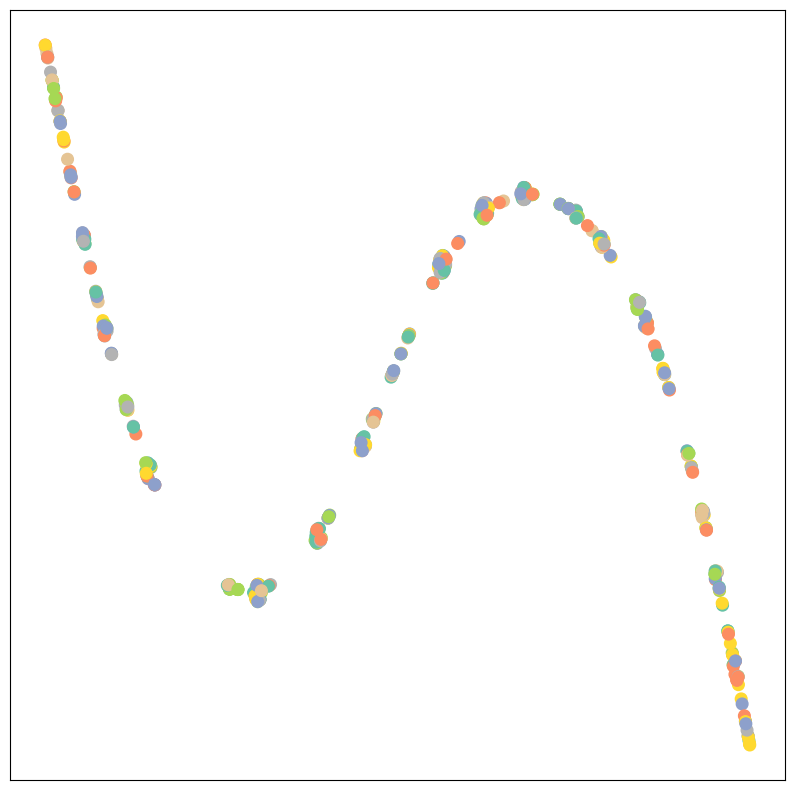

In [45]:
A = torch.tensor(A_train.todense()).to(device)
H = H_train.to(device)
out = model(A, H).squeeze(1)
visualize(out[:500], y_train[:500])



In [ ]:
#torch.norm(, p = 'fro')

## Some things ive learned
* you can define an array, and its reshaped representation. If you dont redefine array, you can change it, and reshaped representation will also change (duh)

In [ ]:
asd = torch.arange(2,5,1);print(asd)
asd2 = asd.reshape(-1,1);print(asd2)
asd += torch.arange(3,6,1);print(asd)
print(asd2)

tensor([2, 3, 4])
tensor([[2],
        [3],
        [4]])
tensor([5, 7, 9])
tensor([[5],
        [7],
        [9]])
